In 1987, a paper was published in the *Journal of Chronic Disease* titled *A New Method of Classifying Prognostic Comorbidity in Longitudinal Studies: Development and Validation*. This was one of the first papers that created a clinical risk score that could be easily computed and could predict clinical outcomes. To give you an idea of how popular this score is, it has been cited 27,497 times at the time that this assignment was created. As a note, comorbidity describes how many different diseases a patient has. 

In 1987, statistical methods were not as easy to apply as they are today. In addition, data were much harder to come by and to analyze. Due to the improvement of computing power and general statistical practice, it is now much easier to create clinical risk scores than in the past.

## Task 1: Background

Before you begin creating your own version of the Charlson Comorbidity Index, as it is known, it is important to familiarize yourself with the paper. A copy of it can be found [here](http://www.aqc.ch/download/HSM_Suppl_8_charlson.pdf). 

### Answer the following questions:

#### How many patients' data were used to create the model?

In [722]:
# 59

#### What time frame were the data from?

In [723]:
# one month in 1984

#### How was the model validated?

In [724]:
# The model validated by predicting disease in a cohort of 685 patients with comorbid disease. 
# And this model is compared with Kaplan and Feinstein.

#### How many patients were used to validate the model results?

In [725]:
# 685

#### What were the characteristics of patients in the "Testing population"?

In [726]:
# all women with historically proven primary carcinoma of the breast

___

In the original paper, the conditions listed are not coded in any way. Follow-up papers by [Deyo in 1992](https://www.ncbi.nlm.nih.gov/pubmed/1607900) and [Quan in 2005](https://www.ncbi.nlm.nih.gov/pubmed/16224307), added the ICD-9-CM groupings for the conditions listed in the Charlson Comorbidity Index. In the provided database, a lookup between condition category and code has been provided.

## Task 2: Exploratory Data Analysis and SQL

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

For this project, the data is located [here](https://duke.box.com/s/vx627f0cypndusbl2k6jyqp9vo33d15g). Please download the database and put it in the same directory as this notebook (or in its own separate directory if you choose). **Make sure you add the database to the provided .gitignore file**. 

### General

In [727]:
import sqlite3

In [728]:
connection = sqlite3.connect('mimic_subset.db')

#### List the tables

In [729]:
pd.read_sql("""SELECT name 
               FROM sqlite_master 
               WHERE type ='table' AND 
               name NOT LIKE 'sqlite_%'""", connection)

,name
0,admission
1,diagnosis
2,charlson_codes
3,patient


#### For each table, select a small number of records (rows) and display the columns

In [730]:
admission = pd.read_sql("""SELECT * from admission """, connection)
diagnosis = pd.read_sql("""SELECT * from diagnosis """, connection)
charlson_codes = pd.read_sql("""SELECT * from charlson_codes """, connection)
patient = pd.read_sql("""SELECT * from patient """, connection)

In [731]:
pd.read_sql("""SELECT * from admission LIMIT 10""", connection)

,index,Unnamed: 0,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,...,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,0,2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,None,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,...,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,None,None,BRAIN MASS,0,1
1,1,13,34,34,144319,2191-02-23 05:23:00,2191-02-25 20:20:00,None,EMERGENCY,CLINIC REFERRAL/PREMATURE,...,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,2191-02-23 04:23:00,2191-02-23 07:25:00,BRADYCARDIA,0,1
2,2,17,38,36,165660,2134-05-10 11:30:00,2134-05-20 13:16:00,None,ELECTIVE,PHYS REFERRAL/NORMAL DELI,...,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,None,None,VENTRAL HERNIA/SDA,0,1
3,3,25,459,357,101651,2199-10-20 12:05:00,2199-10-23 17:30:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,...,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,2199-10-20 09:34:00,2199-10-20 13:25:00,PNEUMONIA,0,1
4,4,26,460,357,117876,2199-12-21 22:37:00,2200-01-18 11:45:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,...,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,2199-12-21 20:38:00,2199-12-22 00:01:00,ALTERED MENTAL STATUS,0,1
5,5,90,88,85,112077,2167-07-25 18:49:00,2167-07-30 15:24:00,None,EMERGENCY,CLINIC REFERRAL/PREMATURE,...,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,2167-07-25 16:37:00,2167-07-25 20:46:00,PNEUMONIA,0,1
6,6,115,113,107,182383,2121-11-30 19:24:00,2121-12-05 14:18:00,None,EMERGENCY,CLINIC REFERRAL/PREMATURE,...,Medicare,ENGL,CATHOLIC,SEPARATED,HISPANIC OR LATINO,2121-11-30 16:40:00,2121-11-30 19:57:00,HYPERKALEMIA;CONGESTIVE HEART FAILURE,0,1
7,7,116,114,107,174162,2122-05-14 19:37:00,2122-05-18 15:11:00,None,EMERGENCY,CLINIC REFERRAL/PREMATURE,...,Medicare,ENGL,CATHOLIC,SEPARATED,HISPANIC OR LATINO,2122-05-14 12:29:00,2122-05-14 20:53:00,UPPER GI BLEED,0,1
8,8,127,125,109,147469,2141-06-11 10:17:00,2141-06-17 16:29:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,...,Medicaid,ENGL,NOT SPECIFIED,SINGLE,BLACK/AFRICAN AMERICAN,2141-06-11 07:02:00,2141-06-11 11:50:00,HYPERTENSIVE EMERGENCY,0,1
9,9,130,169,124,138376,2165-12-31 18:55:00,2166-02-01 06:55:00,2166-02-01 06:55:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,...,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,None,None,PNEUMONIA;CHRONIC OBST PULM DISEASE,1,1


In [732]:
pd.read_sql("""SELECT * from diagnosis LIMIT 10""", connection)

,index,Unnamed: 0,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,0,0,1297,109,172335,1.0,40301
1,1,1,1298,109,172335,2.0,486
2,2,2,1299,109,172335,3.0,58281
3,3,3,1300,109,172335,4.0,5855
4,4,4,1301,109,172335,5.0,4254
5,5,5,1302,109,172335,6.0,2762
6,6,6,1303,109,172335,7.0,7100
7,7,7,1304,109,172335,8.0,2767
8,8,8,1305,109,172335,9.0,7243
9,9,9,1306,109,172335,10.0,45829


In [733]:
pd.read_sql("""SELECT * from charlson_codes LIMIT 10""", connection)

,index,code,category
0,0,410,MI
1,1,4100,MI
2,2,41000,MI
3,3,41001,MI
4,4,41002,MI
5,5,41003,MI
6,6,41004,MI
7,7,41005,MI
8,8,41006,MI
9,9,41007,MI


In [734]:
pd.read_sql("""SELECT * from patient LIMIT 10""", connection)

,index,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,0,234,249,F,2075-03-13 00:00:00,None,None,None,0
1,1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,None,1
2,2,236,251,M,2090-03-15 00:00:00,None,None,None,0
3,3,237,252,M,2078-03-06 00:00:00,None,None,None,0
4,4,238,253,F,2089-11-26 00:00:00,None,None,None,0
5,5,239,255,M,2109-08-05 00:00:00,None,None,None,0
6,6,240,256,M,2086-07-31 00:00:00,None,None,None,0
7,7,241,257,F,2031-04-03 00:00:00,2121-07-08 00:00:00,2121-07-08 00:00:00,2121-07-08 00:00:00,1
8,8,242,258,F,2124-09-19 00:00:00,None,None,None,0
9,9,243,260,F,2105-03-23 00:00:00,None,None,None,0


### Patients:

#### What is the breakdown of gender for patients?

In [735]:
pd.read_sql("""SELECT GENDER,
               COUNT() AS COUNT
               FROM patient
               GROUP BY GENDER""", connection)

,GENDER,COUNT
0,F,20399
1,M,26121


#### Of the patients in the patients table, how many of them have a death date listed? 

In [736]:
patient['DOD'].count()

15759

### Admissions:

#### How many unique patients are there in the admissions dataset?

In [737]:
admission['SUBJECT_ID'].nunique()

17680

#### How many unique encounters are there in this dataset?

In [738]:
admission['HADM_ID'].nunique()

21879

#### How many encounters have an ED time (either registration or out) listed?

In [739]:
admission[pd.notna(admission['EDREGTIME'])]['HADM_ID'].nunique()

14495

#### List the primary diagnoses (Diagnosis field) in order of their prevalence

In [740]:
pd.read_sql("""SELECT DISTINCT DIAGNOSIS,
               COUNT(DIAGNOSIS) AS DIAGNOSIS_COUNT 
               FROM admission
               GROUP BY DIAGNOSIS
               ORDER BY DIAGNOSIS_COUNT DESC""", connection)

,DIAGNOSIS,DIAGNOSIS_COUNT
0,PNEUMONIA,969
1,SEPSIS,501
2,ALTERED MENTAL STATUS,477
3,INTRACRANIAL HEMORRHAGE,441
4,CONGESTIVE HEART FAILURE,418
...,...,...
6747,(AML) ACUTE MYELOGENOUS LEUKEMIA;HYPOTENSION,1
6748,THORACIC ANEURYSM\REPLACEMENT OF ASCENDING AO...,1
6749,STEMI,1
6750,? SEROTONIN SYNDROME,1


#### Now list the count of diagnoses along with the diagnosis name only for patients who died in their hospital stay in descending order

In [741]:
pd.read_sql("""SELECT DISTINCT DIAGNOSIS,
               COUNT(DEATHTIME) AS DEATHTIME_COUNT
               FROM admission
               GROUP BY DIAGNOSIS
               HAVING  COUNT(DEATHTIME) > 0
               ORDER BY DEATHTIME_COUNT DESC""", connection)

,DIAGNOSIS,DEATHTIME_COUNT
0,PNEUMONIA,150
1,INTRACRANIAL HEMORRHAGE,138
2,SEPSIS,100
3,ALTERED MENTAL STATUS,54
4,CONGESTIVE HEART FAILURE,49
...,...,...
929,? AORTIC DISSECTION,1
930,12-AQV,1
931,(AML) ACUTE MYELOGENOUS LEUKEMIA;HYPOTENSION,1
932,(AML) ACUTE MYELOGENOUS LEUKEMIA,1


### Charlson Codes:

#### How many categories are there? 

In [742]:
charlson_codes['category'].nunique()

17

### Diagnoses

#### What is the minimum, average, and maximum count of codes that is given to a patient at a particular encounter?

In [743]:
diagnosis.groupby('HADM_ID')['ICD9_CODE'].count().agg([pd.np.min, pd.np.mean, pd.np.max])

amin     1.000000
mean    14.632936
amax    39.000000
Name: ICD9_CODE, dtype: float64

### Combined information

#### There is a `DEATHTIME` column in the admission table. In addition, there is death information present in the patient table. Is the information in the admission table complete? (Are there patients who have death information in the patient table who do not have the same information in the admissions table?)

In [744]:
pd.read_sql("""SELECT new_admission.DEATHTIME_COUNT, patient.EXPIRE_FLAG 
FROM (SELECT SUBJECT_ID,
      COUNT(admission.DEATHTIME) AS DEATHTIME_COUNT 
FROM admission 
GROUP BY admission.SUBJECT_ID) AS new_admission

INNER JOIN patient on new_admission.SUBJECT_ID = patient.SUBJECT_ID
WHERE (new_admission.DEATHTIME_COUNT !=0 and patient.EXPIRE_FLAG = 0) or (new_admission.DEATHTIME_COUNT =0 and patient.EXPIRE_FLAG = 1)""", connection)

,DEATHTIME_COUNT,EXPIRE_FLAG
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
3180,0,1
3181,0,1
3182,0,1
3183,0,1


In [745]:
# No, the admission table is not complete. There are 3185 patients show death without death time information.

#### Join the diagnosis and the Charlson tables together by code and list the Charlson Categories and their counts in descending order

In [746]:
pd.read_sql("""SELECT DISTINCT category,
               COUNT(category) AS CATEGORY_COUNT
FROM(SELECT *
    FROM diagnosis
    LEFT JOIN charlson_codes ON diagnosis.ICD9_CODE = charlson_codes.code)
GROUP BY category
HAVING category_COUNT > 0
ORDER BY category_COUNT DESC""", connection)

,category,CATEGORY_COUNT
0,CHF,11347
1,Pulmonary,6402
2,Renal,6209
3,DM,5295
4,Stroke,4041
5,MI,3457
6,LiverMild,3407
7,PVD,2918
8,Mets,2902
9,Cancer,2901


## Task 3: Visualization

#### Create a length of stay (in days) column in the dataframe. The Length of Stay is defined as the discharge time minus the admission time. 

In [747]:
length_stay = admission
length_stay['LENGTH_OF_STAY'] = (pd.to_datetime(length_stay['DISCHTIME']) - pd.to_datetime(length_stay['ADMITTIME'])).dt.days

#### Create a plot which contains boxplots that contain the length of stay information, broken down by Admission Type

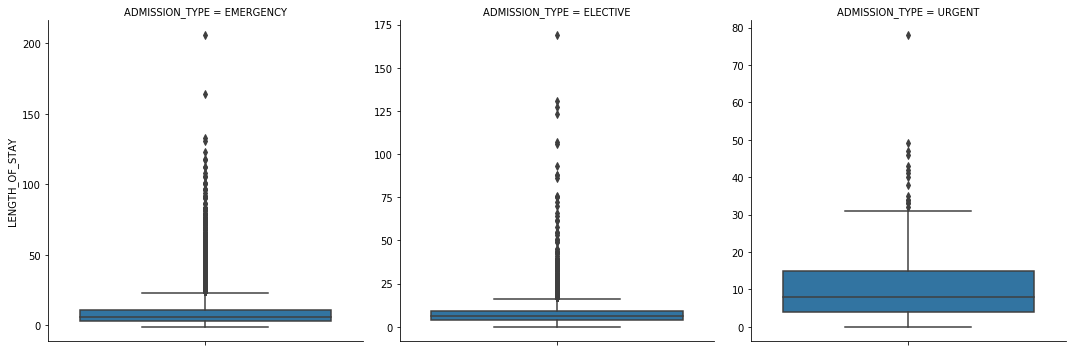

In [748]:
LengthofStay_df = length_stay[['ADMISSION_TYPE','LENGTH_OF_STAY']]
g = sns.catplot(y ='LENGTH_OF_STAY', data = LengthofStay_df, col ='ADMISSION_TYPE',kind ='box', sharey = False)

#### Ask your own question about the data and answer it with a visualization of your choice

In [764]:
# Does admission type affects the length of stay?

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: float
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: [(`~matplotlib.path.Path`, `.Transform`) | `.Patch` | None]
  color or c: color
  contains: callable
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font_properties: `.font_manager.FontProperties`
  fontsize or size: {size in points, 'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or variant: {'normal', 'small-caps'}
  fontweight or w

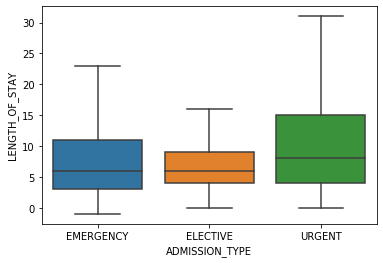

In [765]:
# The outliers prevent good visualize so I will do boxplot without them,
g = sns.boxplot(x ='ADMISSION_TYPE', y ='LENGTH_OF_STAY', data = length_stay_codes, showfliers = False)
plt.setp(g.get_xticklabels());

#### Create a scatter plot which has the length of stay in days on one axis and the number of diagnosis codes for a particular encounter on the other

In [755]:
code_df = diagnosis.groupby('HADM_ID')['ICD9_CODE'].count()
code_df = pd.DataFrame({'HADM_ID':code_df.index, 'NUM_CODE':code_df.values})
code_df

,HADM_ID,NUM_CODE
0,100001,16
1,100003,9
2,100009,18
3,100010,5
4,100011,14
...,...,...
21874,199972,16
21875,199979,10
21876,199984,13
21877,199992,15


In [756]:
length_stay_codes = pd.merge(length_stay, code_df, on ='HADM_ID')
length_stay_codes.head()

,index,Unnamed: 0,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,...,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,LENGTH_OF_STAY,NUM_CODE
0,0,2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,None,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,...,CATHOLIC,MARRIED,WHITE,None,None,BRAIN MASS,0,1,6,10
1,1,13,34,34,144319,2191-02-23 05:23:00,2191-02-25 20:20:00,None,EMERGENCY,CLINIC REFERRAL/PREMATURE,...,CATHOLIC,MARRIED,WHITE,2191-02-23 04:23:00,2191-02-23 07:25:00,BRADYCARDIA,0,1,2,8
2,2,17,38,36,165660,2134-05-10 11:30:00,2134-05-20 13:16:00,None,ELECTIVE,PHYS REFERRAL/NORMAL DELI,...,NOT SPECIFIED,MARRIED,WHITE,None,None,VENTRAL HERNIA/SDA,0,1,10,12
3,3,25,459,357,101651,2199-10-20 12:05:00,2199-10-23 17:30:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,...,NOT SPECIFIED,MARRIED,WHITE,2199-10-20 09:34:00,2199-10-20 13:25:00,PNEUMONIA,0,1,3,17
4,4,26,460,357,117876,2199-12-21 22:37:00,2200-01-18 11:45:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,...,NOT SPECIFIED,MARRIED,WHITE,2199-12-21 20:38:00,2199-12-22 00:01:00,ALTERED MENTAL STATUS,0,1,27,22


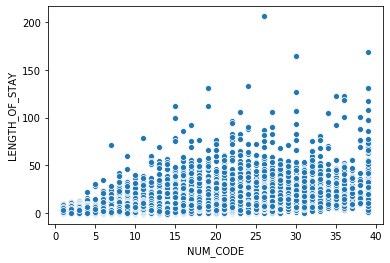

In [757]:
sns.scatterplot(x ='NUM_CODE', y ='LENGTH_OF_STAY', data = length_stay_codes)

## Task 4: Create the Design/Model matrix 

For this task, you will create the Design/Model matrix for your clinical risk score. Each row should pertain to a unique encounter, and the columns should be each of the categories available in the `charlson_codes` table. 

In particular, you will need to detect the presence of an ICD-code that belongs to a category in the Charlson Comorbidity Index, and make the corresponding entry a 1 if it is present, and a 0 if it is not. 

In addition, you should create a column that contains the value 1.0 repeated to represent the intercept weight. 

Finally, you will need 1 column that represents whether a patient's death date is within 1 year of their encounter `ADMITTIME`.

Below are a list of steps that can walk you through the process. You do not need to necessarily follow these steps, but at the end you should end up with a matrix that looks something like this (with all of the category columns)


##### As a DataFrame

In [766]:
df = pd.DataFrame({'CHF': [1, 0], 'MI': [1, 0], 'Stroke': [1, 0], '1 year mortality': [1, 0]})
df

,CHF,MI,Stroke,1 year mortality
0,1,1,1,1
1,0,0,0,0


##### As a Numpy array

In [767]:
df.values

array([[1, 1, 1, 1],
       [0, 0, 0, 0]], dtype=int64)

### Recommended Steps for Creating the Design Matrix

For this task, you will need to use the `admission`, `diagnosis`, `charlson_codes`, and `patient` tables. 

To get an accurate death date at the encounter level, join the patient table into the admission table by patient identifier. From there, create a new column that determines whether there has been 1 year or less between the mortality(death) date and the admission time. 

Remember that when working with datetime columns, you will need to utilize the `pd.to_datetime` function. You can subtract times and use the `.dt.days` method to extract the number of days. [Reference](https://stackoverflow.com/a/45039811)

In [768]:
join_admission_patient = pd.merge(admission, patient, on = 'SUBJECT_ID')
join_admission_patient['1 year mortality'] = ((pd.to_datetime(join_admission_patient['DOD']) - pd.to_datetime(join_admission_patient['ADMITTIME'])).dt.days) < 365
join_admission_patient = join_admission_patient[['HADM_ID','1 year mortality']].set_index('HADM_ID')
join_admission_patient['1 year mortality'] = join_admission_patient['1 year mortality'].astype(int)
join_admission_patient.head()

,1 year mortality
HADM_ID,
124321,0
144319,1
165660,0
101651,0
117876,0


Next, join the `diagnosis` and `charlson_codes` data together. If there is missing information, use the type of join that removes missing information. Not all diagnosis codes map to an existing Charlson category. 

Once you have this new DataFrame, you will notice that it is in a long format. You will need to turn it into a wide format so that each category is represented as its own column. You can start with this command to get started:

`.groupby(['id', 'category']).size().unstack()`

In [769]:
charlson_codes_ICD9 = charlson_codes.rename(columns = {'code':'ICD9_CODE'})
join_diagnosis_charlson = pd.merge(diagnosis, charlson_codes_ICD9, on ='ICD9_CODE')
join_diagnosis_charlson = join_diagnosis_charlson.groupby(['HADM_ID', 'category']).size().unstack()
join_diagnosis_charlson = join_diagnosis_charlson.fillna(0)
join_diagnosis_charlson.head()

category,CHF,Cancer,DM,DMcx,Dementia,HIV,LiverMild,LiverSevere,MI,Mets,PUD,PVD,Paralysis,Pulmonary,Renal,Rheumatic,Stroke
HADM_ID,,,,,,,,,,,,,,,,,
100001,0.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
100003,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
100009,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
100010,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100018,2.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0


You will also need to binarize (turn to 1s and 0s) each of the category columns. 

In [770]:
join_diagnosis_charlson[join_diagnosis_charlson > 0] = 1
join_diagnosis_charlson.head()

category,CHF,Cancer,DM,DMcx,Dementia,HIV,LiverMild,LiverSevere,MI,Mets,PUD,PVD,Paralysis,Pulmonary,Renal,Rheumatic,Stroke
HADM_ID,,,,,,,,,,,,,,,,,
100001,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
100003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
100009,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
100010,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100018,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0


Merge all of the data together so that it looks like the example above.

In [771]:
merge_all = join_diagnosis_charlson.join(join_admission_patient)
merge_all = merge_all[['CHF', 'Cancer', 'DM', 'DMcx', 'Dementia', 'HIV', 'LiverMild','LiverSevere', 'MI', 'Mets', 'PUD', 'PVD', 'Paralysis', 'Pulmonary','Renal', 'Rheumatic', 'Stroke','1 year mortality']]
merge_all.head()

,CHF,Cancer,DM,DMcx,Dementia,HIV,LiverMild,LiverSevere,MI,Mets,PUD,PVD,Paralysis,Pulmonary,Renal,Rheumatic,Stroke,1 year mortality
HADM_ID,,,,,,,,,,,,,,,,,,
100001,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
100003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
100009,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
100010,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
100018,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0


# Task 5: Fit a logistic regression model via gradient descent

Implement the gradient ascent algorithm and use it to iteratively update some initialized weights for your logistic regression. For this step, do not use an implementation in another library (sklearn, statsmodels). You must write your own implementation using base python, numpy, and other standard libraries. If you have a question about what is allowed, please ask one of the instructors.

Recall that the average loss can be expressed as follows (this is usually displayed with a negative sign out front)

$$\frac{1}{m}\sum_{i=1}^{m}y^{(i)} \log \sigma(\textbf{w}^T\textbf{x}^{(i)}) + (1-y^{(i)}) \log (1- \sigma(\textbf{w}^T\textbf{x}^{(i)}) $$

The Gradient Ascent update equation is given by: 
$$ w_j \leftarrow w_j + \alpha(y-\sigma(\textbf{w}^T\textbf{x}))x_j $$

where $\alpha$ is a learning rate which affects the speed of convergence. 

The pseudocode to fit a logistic regression model looks similar to the following:
```    
Repeat {

  1. Calculate average gradient value over the dataset(for all x_j)
  2. Multiply by the average gradient by the learning rate
  3. Update the weights by adding this value to the original weights

}
```

In practice, you will want to initialize an array of weights w of the appropriate size with all 0s or some other small random value. Then, you will follow the pseudocode above, and update the weights iteratively. At each step, you will want to compute the value $y - \sigma(\textbf{w}^T\textbf{x})x_j$ over all of the rows of the matrix and find the average value over the entire dataset. Then apply the learning rate and update the weights according to the update equation above.

In [772]:
def train_model(y,x,alpha,epochs):
    [m,n] = x.shape
    w = np.random.rand(1,n)
    gradient = np.zeros([1,n])
    loss = np.zeros(epochs)
    for epoch in range(epochs):
        #1. Calculate average gradient value for all x_j
        gradient = (y - sigma(np.matmul(x,w.T)))*x
        gradient = np.sum(gradient,axis = 0)/m
        gradient = gradient[...,None].T
        #2. Multiply by the average gradient by the learning rate
        gradient = gradient*alpha
        #3. Update the weights by adding this value to the original weights
        w_save = w
        epoch_save = epoch
        w = w + gradient
        
        loss[epoch] = logistic_loss(x, y,w.T)
        
    return w,loss,w_save,epoch_save

In [773]:
weight

array([[-1.77921185,  0.64577591,  0.99981301, -0.06136049, -0.19462171,
         0.98986952,  0.50850016,  0.39596621,  0.71205589,  0.00837375,
         1.68814159,  0.21662916,  0.09073986,  0.46451465,  0.1243105 ,
         0.56724166,  0.15075709,  0.43859753]])

You will want to repeat this procedure until the algorithm converges. You can play around with the learning rate and the number of total iterations for this program to converge either faster or slower. In addition, you can choose to use other versions of gradient descent, such as mini-batch gradient descent and/or stochastic gradient descent to improve the convergence rate. One way to check for convergence is to check to make sure that the weights are not changing by a certain small threshold. Another way is to run for a number of iterations and check against the `statsmodels` implementation:

```
from statsmodels import api as sm

logit = sm.Logit(y, X)
logit.fit().params
```

**After each iteration,** compute the average loss over the entire dataset (the negative of the expression above) and record this loss in a list. After your algorithm has converged, plot the loss (y-axis) versus the iteration number(x-axis). This will also help you to choose a suitable learning rate

In addition, we will hold out a test set to check whether our model generalizes. To do this, we will set aside 80% of the data for training and 20% for the test set. You will fit the above procedure on the training set to get the parameters and will evaluate your model in task 6. Make sure to save your fit parameters. 

In [774]:
# set a random seed
np.random.seed(2020)

In [775]:
from sklearn.model_selection import train_test_split
# Fill in this function with your dataset. Here,
# X is the Design matrix 
# and y is the label vector
X = numpy_merge_all[:,:-1]
y = numpy_merge_all[:,-1]
y = y[...,None]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

Text(0, 0.5, 'Logistic Loss')

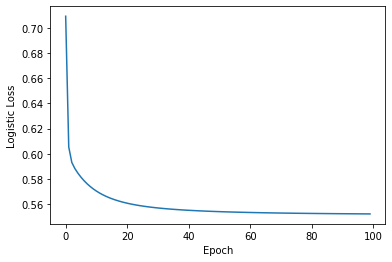

In [776]:
weight,loss,weight_early_stop,stop_epoch = train_model(y_train,X_train,2,100)
fig = plt.figure()
plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('Logistic Loss')

In [777]:
from statsmodels import api as sm

In [778]:
logit = sm.Logit(y_train,X_train)
weight_from_library=logit.fit().params

Optimization terminated successfully.
         Current function value: 0.551430
         Iterations 5


# Task 6: Compare your model to the Charlson Comorbidity Index 

Below is a table of Charlson Comordibity Weights: 

![](./assets/charlson_weights.png)

Using our subset of diagnosis categories, assign a score to each patient in your test set by multiplying the condition by the associated weight and summing up the entries. Specifically, use the following:

In [779]:
charlson_scores = pd.DataFrame({'Category': [
                            'chf', 
                            'Cancer', 
                            'DM', 
                            'DMcx', 
                            'Dementia', 
                            'HIV', 
                            'LiverMild',
                            'LiverSevere',
                            'MI',
                            'Mets', 
                            'PUD',
                            'PVD',
                            'Paralysis', 
                            'Pulmonary',
                            'Renal',
                            'Rheumatic',
                            'Stroke'
                            ],
              'Score': [1,1,1,2,1,6,3,3,1,2,1,1,1,1,2,1,1]})


charlson_scores

,Category,Score
0,chf,1
1,Cancer,1
2,DM,1
3,DMcx,2
4,Dementia,1
5,HIV,6
6,LiverMild,3
7,LiverSevere,3
8,MI,1
9,Mets,2


In [780]:
from sklearn.metrics import roc_auc_score

The metric that we will be using to compare the models will be the Area Under the Receiver Operator Characteristic Curve (AUROC). The sklearn function for this is sklearn.metrics.roc_auc_score. You can find out the signature by looking at the documentation or using `?roc_auc_score`

**Your Task**: Create 2 separate sets of predictions: 1 which is just the Charlson score (multiply each row of your design matrix [training set] by the above table while making sure to match the right comorbidity to the right column of your training set) and the other which is your logistic regression (apply the logistic regression formula with the coefficients/weights that you learned). Show the performance on the test set and compare them. How does each of them do?

In [781]:
charlson_scores_np = charlson_scores['Score'].to_numpy()
charlson_scores_np = np.insert(charlson_scores_np,0,0) 
charlson_prediction = np.matmul(X_test,charlson_scores_np.T)
print('Charlson AUC: {}'.format(roc_auc_score(y_test, charlson_prediction)))

Charlson AUC: 0.6241130378001887


In [782]:
logistic_regression_prediction = np.matmul(X_test,weight_early_stop.T)
print('logistic regression AUC: {}'.format(roc_auc_score(y_test, logistic_regression_prediction)))

logistic regression AUC: 0.7099183777116738


In [783]:
#Logistic regression is better than Charlson score.